## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Data wrangling](#1_Data_wrangling)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Imports](#1.3_Imports)
  * [1.4 Objectives](#1.4_Objectives)
  * [1.5 Load The Historical CPI Data](#1.5_Load_The_Historical_CPI_Data)
  * [1.6 Explore The Data](#1.6_Explore_The_Data)
    * [1.6.1 Find Your Resort Of Interest](#1.6.1_Find_Your_Resort_Of_Interest)
    * [1.6.2 Number Of Missing Values By Column](#1.6.2_Number_Of_Missing_Values_By_Column)
    * [1.6.3 Categorical Features](#1.6.3_Categorical_Features)
      * [1.6.3.1 Unique Resort Names](#1.6.3.1_Unique_Resort_Names)
      * [1.6.3.2 Region And State](#1.6.3.2_Region_And_State)
      * [1.6.3.3 Number of distinct regions and states](#1.6.3.3_Number_of_distinct_regions_and_states)
      * [1.6.3.4 Distribution Of Resorts By Region And State](#1.6.3.4_Distribution_Of_Resorts_By_Region_And_State)
      * [1.6.3.5 Distribution Of Ticket Price By State](#1.6.3.5_Distribution_Of_Ticket_Price_By_State)
        * [1.6.3.5.1 Average weekend and weekday price by state](#1.6.3.5.1_Average_weekend_and_weekday_price_by_state)
        * [1.6.3.5.2 Distribution of weekday and weekend price by state](#1.6.3.5.2_Distribution_of_weekday_and_weekend_price_by_state)
    * [1.6.4 Numeric Features](#1.6.4_Numeric_Features)
      * [1.6.4.1 Numeric data summary](#1.6.4.1_Numeric_data_summary)
      * [1.6.4.2 Distributions Of Feature Values](#1.6.4.2_Distributions_Of_Feature_Values)
        * [1.6.4.2.1 SkiableTerrain_ac](#1.6.4.2.1_SkiableTerrain_ac)
        * [1.6.4.2.2 Snow Making_ac](#1.6.4.2.2_Snow_Making_ac)
        * [1.6.4.2.3 fastEight](#1.6.4.2.3_fastEight)
        * [1.6.4.2.4 fastSixes and Trams](#1.6.4.2.4_fastSixes_and_Trams)
  * [1.7 Derive State-wide Summary Statistics For Our Market Segment](#1.7_Derive_State-wide_Summary_Statistics_For_Our_Market_Segment)
  * [1.8 Drop Rows With No Price Data](#1.8_Drop_Rows_With_No_Price_Data)
  * [1.9 Review distributions](#1.9_Review_distributions)
  * [1.10 Population data](#1.10_Population_data)
  * [1.11 Target Feature](#1.11_Target_Feature)
    * [1.11.1 Number Of Missing Values By Row - Resort](#1.11.1_Number_Of_Missing_Values_By_Row_-_Resort)
  * [1.12 Save data](#1.12_Save_data)
  * [1.13 Summary](#1.13_Summary)


## 1.2 Introduction<a id='2.2_Introduction'></a>

This step focuses on collecting data, organizing it, and making sure it's well defined. Specifically, we have two sets of data - the historical data and the recent data are spread into two sets. 

### 1.2.1 Recap Of Data Science Problem<a id='1.2.1_Recap_Of_Data_Science_Problem'></a>

The purpose of this data science project is to come up with a forecasting model for organizations such as the federal reserve or any private business that is interested in forecasting the inflation rate in the near future. The Federal Reserve’s dual mandate requires monetary policy to aim for both maximum employment and price stability. [As the RMSEs show](https://www.clevelandfed.org/en/newsroom-and-events/publications/economic-trends/2011-economic-trends/et-20110107-the-accuracy-of-cpi-inflation-forecasts.aspx), the accuracy of inflation forecasts has varied a lot over time. Inflation forecasts were not very accurate in the 1970s and 1980s. Accuracy improved in the 1990s and began to fall again in the 2000s. 

This model is aimed to utilize disaggregate information to improve the forecast accuracy for the aggregated inflation rate. The disaggregated information has been proposed by [many researchers](https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp589.pdf) with a dynamic factor model to reduce the dimensionality. However, the findings are mixed. This project aims to identify a statistical model that can improve the dynamic factor model in accuracy.  

The final product of the project is to generate a inflation forecasting for the next 12 months in a highly automated manner. 

## 1.3 Imports<a id='1.3_Imports'></a>

In [2]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from library.sb_utils import save_file

## 1.4 Objectives<a id='1.4_Objectives'></a>

There are some fundamental goals of the data wrangling process:

* Clean the data and create a data set for the model.

* Create a pipeline function that combines recently released CPI data with the historical data. 

* Identify the fundamental issues with the data.

## 1.5 Load The Historical CPI Data<a id='1.5_Load_The_Historical_CPI_Data'></a>

There are 15 disaggregated features to be imported from the raw data. First of all, we import all the data frames and clean them one by one. To achieve this, I create a function that does data importation and cleaning automatically. 

In [37]:
# the supplied CSV data file is the raw_data directory
import calendar
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt

names = []
for root, dirs, files in os.walk("../data/raw_data"):
    for filename in files:
        names.append(filename)

        
def function(name):
    df = pd.read_excel('../data/raw_data/' + name)[10:]
    df.columns = list(df.iloc[0])
    df.drop(10, inplace = True)
    df.drop(['HALF1', 'HALF2'], axis = 1, inplace = True)
    df.set_index('Year', inplace = True)
    raw_cpi = [list(df.iloc[i]) for i in range(0,df.shape[0])]
    cpi = np.reshape(raw_cpi, (12 * df.shape[0]))
    date = [datetime(year=y, month=m, day=calendar.monthrange(y,m)[1]) for y in range(df.index[0],df.index[-1] + 1) for m in range(1,13)]
    return pd.DataFrame({'date':date, name[0:-5]:cpi}) 


dfs = [function(name) for name in names]
df_final = reduce(lambda left,right: pd.merge(left,right,on='date',how = 'left'), dfs)
df_final.dropna(inplace = True)


In [38]:
#Call the head method on df_final to see a summary of the data
df_final.head()

,date,Medical care services,Transportation services,Electricity,Food at home,Alcoholic beverages,Utility (piped) gas service,Commodities less food and energy commodities,Food away from home,Shelter,Motor fuel,Services less energy services,Fuel oil and other fuels,All items,Medical care commodities,Apparel
266,1957-03-31,16.8,23.7,28.7,30.2,42.1,15.0,37.1,23.2,23.7,24.0,21.7,14.2,27.8,44.0,44.4
269,1957-06-30,17.0,24.0,28.7,30.6,42.0,14.9,37.3,23.4,23.9,23.9,21.8,13.8,28.1,44.7,44.4
272,1957-09-30,17.1,24.4,28.7,30.9,42.1,15.3,37.5,23.7,24.2,23.7,22.1,13.9,28.3,44.8,44.7
275,1957-12-31,17.4,24.6,28.8,30.9,42.1,15.4,37.8,23.8,24.3,23.7,22.3,14.1,28.4,45.4,44.8
278,1958-03-31,17.6,25.5,28.9,32.4,42.1,15.8,37.7,23.9,24.4,23.4,22.6,13.9,28.8,45.9,44.6


## 1.6 Tidy Data<a id='1.6_Tidy_Data'></a>

In [63]:
formatted_df = pd.melt(df_final,
                       ["date"],
                       var_name="sector",
                       value_name="CPI")
formatted_df = formatted_df.sort_values(by=["date"])
formatted_df.reset_index(inplace = True)
formatted_df.drop('index', axis = 1, inplace = True)
formatted_df.head()

,date,sector,CPI
0,1957-03-31,Medical care services,16.8
1,1957-03-31,Commodities less food and energy commodities,37.1
2,1957-03-31,Motor fuel,24.0
3,1957-03-31,Shelter,23.7
4,1957-03-31,Food away from home,23.2


## 1.7 Plot CPI Data<a id='1.7_Plot_CPI_Data'></a>

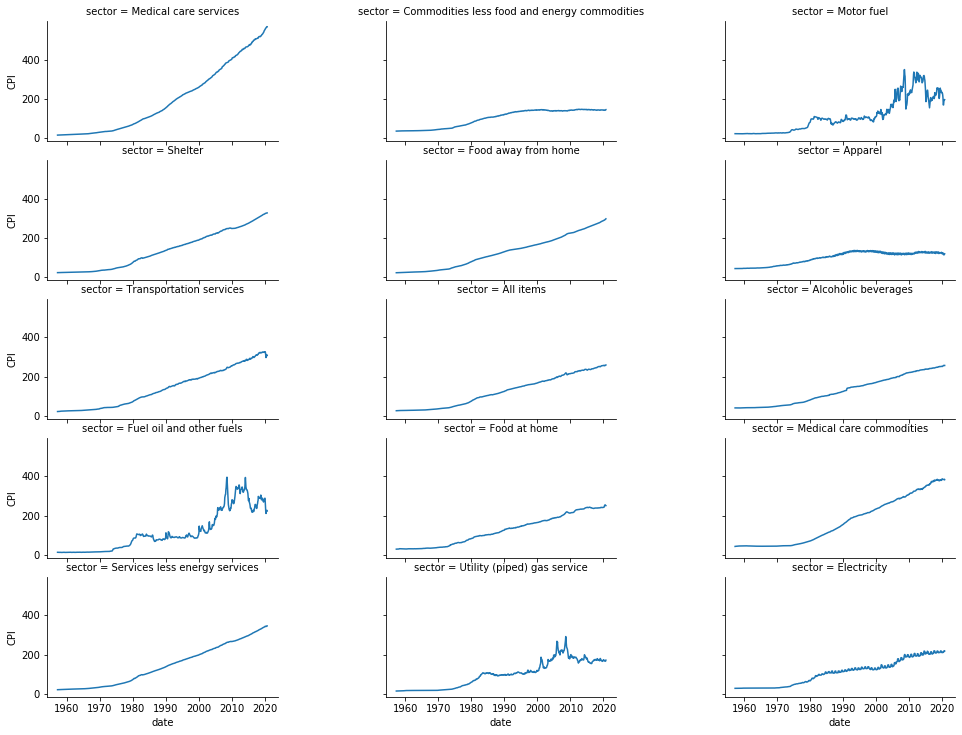

In [74]:
g = sns.FacetGrid(formatted_df, col="sector", col_wrap=3)
g.map(sns.lineplot, "date", "CPI")
g.fig.set_size_inches(14,10)

## 1.8 Compute Growth Rate<a id='1.8_Compute_Growth_Rate'></a>

The disaggregated data set has a tree structure. The variable `Terminal_Category` indicates whether the tree ends as a leaf in a specific sector. Here I show that the tree structure is unbalanced with terminal nodes showing up on multiple levels. 

In [4]:
def count_level(historical_cpi, level):
    selected_columns = historical_cpi.columns[(historical_cpi.iloc[1] == level)]
    return len(selected_columns), sum(historical_cpi[selected_columns].iloc[2] == 1)

count_df = pd.DataFrame([count_level(historical_cpi, level) for level in range(0,10)], columns = ['#Categories', '#Terminal'])
count_df.index.name = 'Disaggregation Level'
count_df

,#Categories,#Terminal
Disaggregation Level,,
0,1,0
1,2,0
2,4,1
3,15,0
4,54,9
5,129,96
6,94,84
7,26,22
8,9,9


This analysis shows that the first terminal node shows up in disaggregation level 2. The data structure is not balanced in general, with terminal nodes showing up at multiple levels. The deepest disaggregation is level 8, which is the upper bound for the feature selection in terms of disaggregation. The following subsection highlights the feature selection strategy for the disaggregated data set.

## 1.6.2 Level Selection Strategy<a id='1.6.2_Level Selection_Strategy'></a>

The following tree structure is a generic unbalanced tree. It only serves to demonstrate the level selection strategy. 

-If the disaggregation level is 0, we only use variable `7` as the feature.

-If the disaggregation level is 1, we only use variable `3` and `11` as the features. 

-If the disaggregation level is 2, we only use variable `1`, `5`, `9`, `13` as the features. 

-If the disaggregation level is 3, we only use variable `1`, `4`, `6`, `9`, `12`, `14` as the features. 

<img src="../images/data_structure_demo.png" width="480">


<br>Two things to note for this level selection strategy. If we choose the level to be 0, we discard all the disaggregated information and only use the aggregated information to predict. We don't repeat the more aggregated information if all the disaggregated information is selected. For example, at level 1, we only choose `3` and `11` and *not* `7` to avoid redundancy. If the level contains missing nodes, we go up to find the nearest parent as a substitute. That's why node `1` and `9` are included when we choose level 3.

## 1.6.3 Selecting Features with Level <a id='1.6.3_Selecting_Features_with_Level'></a>

Here I briefly describe the algorithm that I use to apply the level selecting strategy given level `l`:

1. Select all the features in the level `l`;
2. Go back to level `l-1` and add all the terminal features;
3. Repeat step 2 until the level hits 0, then stop;

In [5]:
# Create a function that selects the features according to a level
def extract_level(historical_cpi, level):
    selected_columns = list(historical_cpi.columns[(historical_cpi.iloc[1] == level)])
    while level > 0:
        level = level - 1
        selected_columns_add_candidates = list(historical_cpi.columns[(historical_cpi.iloc[1] == level)])
        bool_list = list(historical_cpi[selected_columns_add_candidates].iloc[2] == 1)
        add_index = [i for i, val in enumerate(bool_list) if val] 
        selected_columns += [selected_columns_add_candidates[i] for i in add_index]
    return selected_columns


select_df = pd.DataFrame([len(extract_level(historical_cpi, level)) for level in range(0,9)], columns = ['#Features'])
select_df.index.name = 'Disaggregation Level'
select_df


,#Features
Disaggregation Level,
0,1
1,2
2,4
3,16
4,55
5,139
6,200
7,216
8,221


The table above shows that when we choose a deeper level of disaggregation, more features get selected. One question that naturally arises is which level of disaggregation should we use. If the level is too small, then we are not fully utilizing the disaggregated data. If the level is too high, we might risk incorporating too much noise and overfitting the model. 

In [6]:
extract_level(historical_cpi, 3)

['Motor vehicles and parts',
 'Furnishings and durable household equipment',
 'Recreational goods and vehicles',
 'Other durable goods',
 'Food and beverages purchased for off-premises consumption',
 'Clothing and footwear',
 'Gasoline and other energy goods',
 'Other nondurable goods',
 'Housing and utilities',
 'Health care',
 'Transportation services',
 'Recreation services',
 'Food services and accommodations',
 'Financial services and insurance',
 'Other services',
 'Final consumption expenditures of nonprofit institutions serving households (NPISHs) (132)']

## 1.7 Import Recent CPI Data<a id='1.7_Import_Recent_CPI_Data'></a>

## 1.7.1 Import Raw Data <a id='1.7.1_Convert_CPI_to_Inflation'></a>

In [7]:
historical_cpi

,Date,Personal consumption expenditures,Goods,Durable goods,Motor vehicles and parts,New motor vehicles (55),New autos,New domestic autos,New foreign autos,New light trucks,...,Other household services,Foreign travel by U.S. residents (129),Passenger fares for foreign travel,U.S. travel outside the United States,U.S. student expenditures,Less: Expenditures in the United States by nonresidents (130),Foreign travel in the United States,Medical expenditures of foreigners,Expenditures of foreign students in the United States,Final consumption expenditures of nonprofit institutions serving households (NPISHs) (132)
0,BEA_Line_Number,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,...,326.000,328.000,329.000,330.000,331.000,332.000,333.000,334.000,335.000,336.000
1,Aggregation_Level,0.000,1.000,2.000,3.000,4.000,5.000,6.000,6.000,5.000,...,5.000,4.000,5.000,5.000,5.000,4.000,5.000,5.000,5.000,2.000
2,Terminal_Category,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,...,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000
3,195901,17.124,28.009,54.478,32.602,38.531,38.961,38.943,38.943,36.570,...,9.999,17.004,17.641,16.811,NaN,13.005,14.872,NaN,NaN,54.163
4,195902,17.138,28.022,54.510,32.652,38.530,38.961,38.943,38.943,36.570,...,10.050,17.025,17.699,16.811,NaN,13.073,14.950,NaN,NaN,53.932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,201708,112.629,101.162,86.278,107.990,109.084,103.250,103.261,103.256,112.333,...,117.817,105.739,110.982,101.645,106.260,117.079,113.229,147.591,135.277,117.950
707,201709,113.077,101.876,86.061,107.895,108.688,102.767,102.781,102.777,111.966,...,117.814,108.169,118.160,102.328,106.994,118.789,115.167,147.916,136.095,118.903
708,201710,113.243,101.679,86.023,107.869,108.485,102.437,102.449,102.444,111.794,...,118.676,108.543,121.458,101.668,106.291,119.482,115.887,148.672,136.570,117.452
709,201711,113.515,101.943,85.817,108.125,108.650,102.812,102.822,102.817,111.883,...,118.980,108.245,120.609,101.544,106.153,119.867,116.249,148.874,137.016,118.350


In [8]:
file_name_2017 = "../raw_data/cpi-u-201712.xlsx"
df = pd.read_excel(file_name_2017)  
df

,Unnamed: 0,"Consumer Price Index for All Urban Consumers (CPI-U): U.S. city average, by expenditure category, December 2017",Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43
0,NaN,"[1982-84=100, unless otherwise noted]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Indent Level,Expenditure category,Relative\nimportance\nNov.\n2017,Unadjusted indexes,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,One Month,NaN,NaN,NaN,Twelve Month,NaN,NaN,NaN
3,NaN,NaN,NaN,Dec.\n2016,Jan.\n2017,Feb.\n2017,Mar.\n2017,Apr.\n2017,May\n2017,Jun.\n2017,...,Oct.\n2017-\nNov.\n2017,Nov.\n2017-\nDec.\n2017,Seasonally adjusted effect on All Items\nNov. ...,"Standard error, median price change(2)",Largest (L) or Smallest (S) seasonally adjuste...,NaN,Unadjusted effect on All Items\nDec. 2016-\nDe...,"Standard error, median price change(2)",Largest (L) or Smallest (S) unadjusted change ...,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Date,Percent change,NaN,NaN,Date,Percent change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,NaN,(15) Indexes on a December 2001=100 base.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,NaN,(16) Indexes on a December 1982=100 base.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,NaN,(17) Indexes on a December 1996=100 base.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,NaN,(18) Indexes on a December 1988=100 base.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import requests
import json
#import prettytable
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0','SUUR0000SA0'],"startyear":"2011", "endyear":"2014"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
json_data

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 133,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUUR0000SA0',
    'data': [{'year': '2014',
      'period': 'M12',
      'periodName': 'December',
      'value': '234.812',
      'footnotes': [{}],
      'calculations': {'net_changes': {},
       'pct_changes': {'1': '-0.6', '3': '-1.4', '6': '-1.5', '12': '0.8'}}},
     {'year': '2014',
      'period': 'M11',
      'periodName': 'November',
      'value': '236.151',
      'footnotes': [{}],
      'calculations': {'net_changes': {},
       'pct_changes': {'1': '-0.5', '3': '-0.7', '6': '-0.7', '12': '1.3'}}},
     {'year': '2014',
      'period': 'M10',
      'periodName': 'October',
      'value': '237.433',
      'footnotes': [{}],
      'calculations': {'net_changes': {},
       'pct_changes': {'1': '-0.3', '3': '-0.3', '6': '0.2', '12': '1.7'}}},
     {'year': '2014',
      'period': 'M09',
      'periodName': 'September',
      'value': '238.031',
      'footnotes': [{}],